# CONFUSION Demo Notebook  

This notebook uses visual representations to check the the dimentions of each input and output.

Then, we test different methods for unpacking the linear layer at the end of the recurrent mechanism.

In [1]:
import numpy as np
import pandas as pd
import sys, os
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import talib as ta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# MAKE SURE WE HAVE THE ENVIRONMENT CONFIGURED PROPERLY
%cd ../src/main
SCRIPT_DIR = os.path.dirname(os.path.abspath("."))
if 'backend' not in os.listdir('.'):
    sys.path.insert(0, os.path.abspath(SCRIPT_DIR))

from backend.utils import DataIterGen_V2 
from backend.reinforcement_learning import get_params, rlForwardFunc, tam

/home/jackb/columbia/TFJ-DRL-update1/src/main


Getting CUDA

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device(f'cuda:{torch.cuda.device_count()-1}')
else:
    DEVICE = torch.device('cpu')

WINDOW = 28
NAME = "conf_posthoc_2_"
ENV_SIZE = 128
DEVICE

device(type='cuda', index=0)

### Definining the recurrent attention (supervised) model

We will modify the feed-forward (`nn.Linear`) portion of the model to return the latent representation of the price at $t+1$

Before we have $W_1 \in \mathbb{R^{256 \times \text{env\_size}}}$, $W_2 \in \mathbb{R^{\text{env\_size} \times \text{1}}}$:

$$\hat{\text{price}}_{t+1} = RELU(W_1 \cdot (h_t \oplus \text{attention}(h_t)))W_2$$


To 'crack open' the model we will change its forward function to return the hidden vector $RELU(W_1 \cdot (h_t \oplus \text{attention}(h_t)))$. This is primarily what we will test on.

In [3]:
class GRU(nn.Module):
    def __init__(self, env_size):
        super(GRU, self).__init__()
        self.rnn=nn.GRU(
            input_size=86,
            hidden_size=128,
            num_layers=1,
            batch_first=True
        )
        self.linear1=nn.Linear(256, env_size)
        self.linear2=nn.Linear(env_size, 1)
        self.num_layers=1
        
    def forward(self, x, state, device):
        batch_size,timestep, _=x.shape
        states, state=self.rnn(x, state)
        tamVec=tam(states, device)
        
        #concatVec: batch_size, time_step, hidden_size*2
        #i.e.       batch_size, 24       , 256        
        concatVec=torch.cat([states, tamVec],axis=2)
        envVec=self.linear1(torch.tanh(concatVec.reshape(batch_size*timestep, -1)))
        output=nn.Dropout(p=0.3)(envVec)
        output=nn.ReLU()(output)
        # hidden_output=nn.ReLU()(output) # HERE
        output=self.linear2(output)
        envVec=envVec.reshape(batch_size, timestep, -1)
        return (output.view(batch_size, -1), envVec), state#, hidden_output
  
    def begin_state(self, device, batch_size=1): 
        # `nn.GRU` takes a tensor as hidden state
        return torch.zeros((
                    self.rnn.num_layers, batch_size, 128), device=device)

tam_gru = GRU(env_size=ENV_SIZE).to(DEVICE)
tam_gru

GRU(
  (rnn): GRU(86, 128, batch_first=True)
  (linear1): Linear(in_features=256, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
)

We need to redefine the `rlPolicy` agent as well. The `rlPolicy` agent is the one which recieves the loss at a given timestep $t$ during training, so it needs to pass that loss backwards to the `tam_gru` model as well.

Between the `tam_gru` model and policy agent we add a decoder model which reconstructs the `hidden_state` vector from the `hidden_output` vector.

To train the decoder, need a new loss function on top of the loss function from the paper. This new loss will be the angular difference between the `hidden_output` vector and the `predicted_hidden_output` vector. As we track this loss through time, it may clue us in to the `tam_gru` model's ability to represent the state. Higher loss means the `tam_gru` is treading uncharted territory, so to speak, which makes the policy agent ***confused***. This is how the decoder loss functions as a confusion metric for the model.


In [4]:
class AutoEncoder(nn.Module):
    """Auto-encoder to get a latent representation of the hidden state, 
    then decode to get the confusion"""
    def __init__(self, env_size, device: torch.device, window):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
           nn.Linear(env_size*window, 64),
           nn.LeakyReLU(),
           nn.Dropout(p=0.3),
           nn.Linear(64, 16),
           nn.ReLU(),
           nn.Linear(16, 2)
        )

        self.decoder = nn.Sequential(
           nn.Linear(2, 16),
           nn.LeakyReLU(),
           nn.Dropout(p=0.3),
           nn.Linear(16, 64),
           nn.ReLU(),
           nn.Linear(64, env_size*window)
       )
       
        self.env_size = env_size
        self.window = window
        self.norm = nn.LayerNorm(normalized_shape=[env_size*window])
    def forward(self, x):
        bsize = x.shape[0]
        x = x.flatten(start_dim=1)
        x = self.norm(x)
        hidden = self.encoder(x)
        output = self.decoder(hidden)
        output = output.reshape(bsize, self.window, self.env_size)
        hidden = hidden.reshape(bsize, 1, 2)
        return hidden, output

decoder = AutoEncoder(ENV_SIZE, DEVICE, WINDOW).to(DEVICE)
decoder

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=3584, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=3584, bias=True)
  )
  (norm): LayerNorm((3584,), eps=1e-05, elementwise_affine=True)
)

### Full Monty class

class extending nn.Module containing an instance of both the policy agent and gru-tam model.

Intended to make training easier to implement with PyTorch

In [5]:
class full_monty(nn.Module):
    """RL Policy net modeled by parameters"""
    def __init__(self, env_size, device: torch.device, window):
        super(full_monty, self).__init__()
        
        #self.linear = nn.Linear(32+1, 1)
        
        W, b, h=get_params(env_size+1, device)
        self.device=device
        self.W=nn.Parameter(W)
        self.b=nn.Parameter(b)
        self.h=nn.Parameter(h)
        self.rnn=GRU(env_size)
        self.conf_net = AutoEncoder(env_size, device, window)

        self.device = device

    # Forward pass through the RL Policy network
    def forward(self, x, state):
        # Obtain predictions and environment vector from GRU
        (predP, envVec), state = self.rnn(x, state, self.device)
       
        # get the confusion
        envVec_copy = envVec.clone().detach()
        embed, reconstruction = self.conf_net(envVec_copy)
        bsize, tstep = reconstruction.shape[0], reconstruction.shape[1]
        confusion_for_grad = nn.CosineEmbeddingLoss(reduction='none')(reconstruction.view((bsize*tstep, -1)), envVec_copy.view((bsize*tstep, -1)), torch.ones((bsize*tstep)).to(self.device))
        confusion=confusion_for_grad.clone().detach()
        confusion_for_grad = confusion_for_grad.mean() #nn.CosineEmbeddingLoss()(reconstruction.view((bsize*tstep, -1)), envVec_copy.view((bsize*tstep, -1)), torch.ones((bsize*tstep)).to(self.device))

        # Compute actions based on the environment vector and parameters
        rl_state = torch.concat((envVec, confusion.reshape(bsize, tstep, 1)), dim=2)
        output = rlForwardFunc(rl_state, [self.W, self.b, self.h])

        # Return predictions and actions
        return predP, output, (confusion, confusion_for_grad, embed)
    
    # Initialize the hidden state for the RL Policy network
    def begin_state(self, device, batch_size=1):
        return self.rnn.begin_state(device, batch_size)

combined = full_monty(ENV_SIZE, DEVICE, WINDOW)
combined

full_monty(
  (rnn): GRU(
    (rnn): GRU(86, 128, batch_first=True)
    (linear1): Linear(in_features=256, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=1, bias=True)
  )
  (conf_net): AutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=3584, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=64, out_features=16, bias=True)
      (4): ReLU()
      (5): Linear(in_features=16, out_features=2, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=16, out_features=64, bias=True)
      (4): ReLU()
      (5): Linear(in_features=64, out_features=3584, bias=True)
    )
    (norm): LayerNorm((3584,), eps=1e-05, elementwise_affine=True)
  )
)

### Utility function defined in paper. 

$$R_t = \delta _t z_t - c|\delta_t - \delta_{t-1}| $$

$$U_t = \sum_{t=1}^T R_t$$

# Define the new training function

Implicitly, we have 3 global models working together.

* `tam_gru`
* `decoder`
* `policy_agent`

# Define Confusion Heuristic

In [6]:
from backend.posthoc_functions import (
    train_posthoc as train,
    test_posthoc as test,
    demo_posthoc as demo,
    show_demo_posthoc as show_demo
)

# Train, Test and Demo with Cooper Companies Inc.

In [7]:
stockList1=['COO','COF','ABBV','CCL','AMD','GOOG',
            'ABT','ACN','ADBE','AES','NVDA',
            'AIG','ALL', 'AMG','AMZN','APA','AAPL',
            'AXP','BA','BBY','CAT','GE', 'CSCO', 
            'EA','EQR','FCX','FE',
            'IBM','INTC','JCI','MMM','MO',
            'ORCL','PPL','T','EXPD','VMC','VNO']

In [ ]:
from backend.baseline_functions import train as train_, demo as demo_
# Get Iterators
train_iter, val_iter, test_iter = DataIterGen_V2(0, stockList1, demo=False, window=WINDOW)
# Training for COO 
os.makedirs('./model_weights', exist_ok=True)
TFJDRLconf_COO = full_monty(device=DEVICE, window=WINDOW, env_size=ENV_SIZE)
MAX_EPOCH = 20
optim1 = optim.Adam(TFJDRLconf_COO.parameters(),            lr=0.00005, weight_decay=0.01, eps=4e-6)
optim2 = optim.Adam(TFJDRLconf_COO.conf_net.parameters(),   lr=0.0001) 

loss, conf_lst=train(train_iter, val_iter, net=TFJDRLconf_COO,
                optimizer1=optim1, optimizer2=optim2, device=DEVICE, num_epoch=MAX_EPOCH,
                name=NAME+'COO')

Using periods
Train: ('2013-01-01', '2017-10-01')
Test: ('2018-01-01', '2019-01-01')
Validation: ('2017-10-08', '2018-04-01')
Initializing Training Dataset...Initializing Iterators(dataloaders) From Dataset...[DONE]
Stock ticker: COO
Epoch 0, training loss: 1.75, val utility: -1.31, confusion: 0.911
Epoch 1, training loss: 1.21, val utility: 3.85, confusion: 0.836
Epoch 2, training loss: 0.90, val utility: 3.85, confusion: 0.779
Epoch 3, training loss: 0.70, val utility: 5.18, confusion: 0.737
Epoch 4, training loss: 0.54, val utility: 2.91, confusion: 0.700
Epoch 5, training loss: 0.44, val utility: 4.54, confusion: 0.668
Epoch 6, training loss: 0.38, val utility: 6.00, confusion: 0.648
Epoch 7, training loss: 0.33, val utility: 5.35, confusion: 0.645
Epoch 8, training loss: 0.34, val utility: 5.35, confusion: 0.640
Epoch 9, training loss: 0.29, val utility: 5.35, confusion: 0.634
Epoch 10, training loss: 0.25, val utility: 3.38, confusion: 0.628


The average confusion level is: 0.449
Demo Stock ticker: COO, testing period: 2018-01-01 to 2019-01-01 [YYYY-MM-DD]


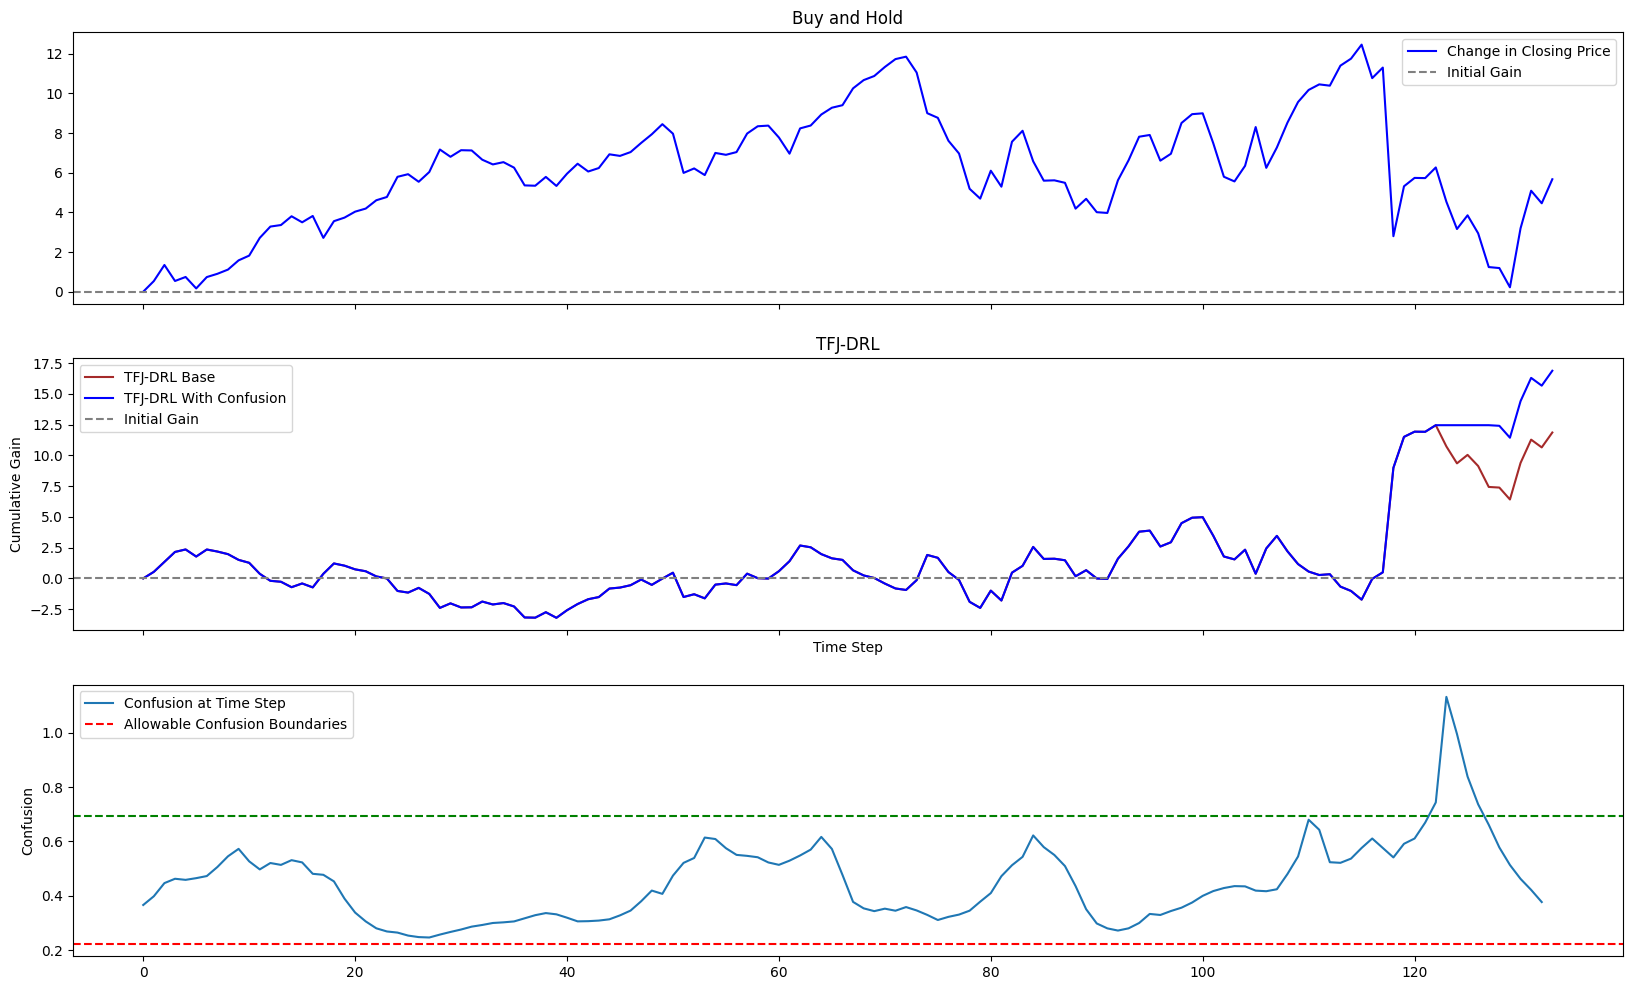

In [ ]:
avgReturn, avgConf=test(net=TFJDRLconf_COO, test_iter=test_iter, device=DEVICE, epoch=MAX_EPOCH, name=NAME+'COO')
print(f'The average confusion level is: {avgConf:.3f}')
demo_iter = DataIterGen_V2(0, stockList1, demo=True, window=WINDOW)
# compute bounds for confusion heuristic
conf_bounds_COO = np.quantile(conf_lst, (.1, .80))
test_result, conf, stock_change, baseReturn = demo(net=TFJDRLconf_COO, demo_iter=demo_iter, device=DEVICE, epoch=MAX_EPOCH , name=NAME+'COO', conf_bounds=conf_bounds_COO)
fig, ax = show_demo(result=test_result, stock_change=stock_change, baseline=baseReturn, conf_list=conf, conf_bounds=conf_bounds_COO)

# Train, Test and Demo with Capital One Financial Corp.

Using periods
Train: ('2013-01-01', '2017-10-01')
Test: ('2018-01-01', '2019-01-01')
Validation: ('2017-10-08', '2018-04-01')
Initializing Training Dataset...Initializing Iterators(dataloaders) From Dataset...[DONE]
Stock ticker: COF
Epoch 0, training loss: 1.77, val utility: 2.45, confusion: 0.937
Epoch 1, training loss: 1.24, val utility: 7.86, confusion: 0.895
Epoch 2, training loss: 1.03, val utility: 6.23, confusion: 0.874
Epoch 3, training loss: 0.88, val utility: 5.55, confusion: 0.872
Epoch 4, training loss: 0.79, val utility: 4.77, confusion: 0.874
Epoch 5, training loss: 0.72, val utility: 5.85, confusion: 0.880
Epoch 6, training loss: 0.69, val utility: 7.24, confusion: 0.881
Epoch 7, training loss: 0.64, val utility: 5.85, confusion: 0.901
Epoch 8, training loss: 0.60, val utility: 3.53, confusion: 0.906
Epoch 9, training loss: 0.58, val utility: 3.53, confusion: 0.907
Epoch 10, training loss: 0.53, val utility: 3.53, confusion: 0.906
Epoch 11, training loss: 0.52, val util

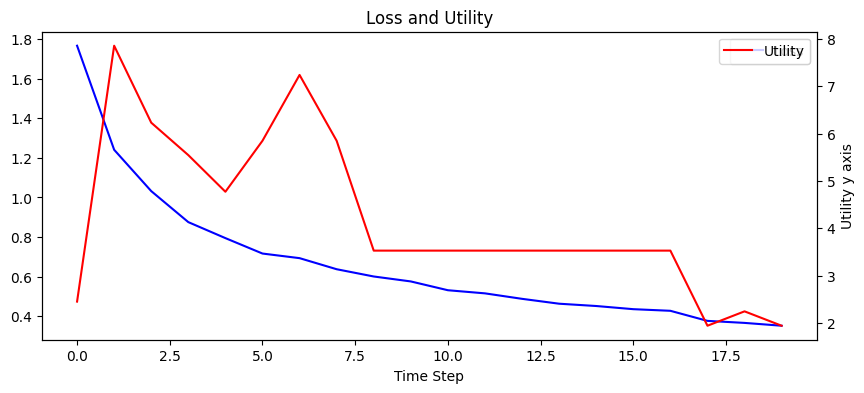

In [30]:
from backend.baseline_functions import train as train_, demo as demo_
# Get Iterators
train_iter, val_iter, test_iter = DataIterGen_V2(1, stockList1, demo=False, window=WINDOW)
# Training for COF 
os.makedirs('./model_weights', exist_ok=True)
TFJDRLconf_COF = full_monty(device=DEVICE, window=WINDOW, env_size=ENV_SIZE)
optim1 = optim.Adam(TFJDRLconf_COF.parameters(),            lr=0.00005, weight_decay=0.01, eps=4e-6)
optim2 = optim.Adam(TFJDRLconf_COF.conf_net.parameters(),   lr=0.0001)
loss, conf_data_COF=train(train_iter, val_iter, net=TFJDRLconf_COF,
                optimizer1=optim1, optimizer2=optim2, device=DEVICE, num_epoch=MAX_EPOCH,
                name=NAME+'COF')

The average confusion level is: 0.449
Demo Stock ticker: COF, testing period: 2018-01-01 to 2019-01-01 [YYYY-MM-DD]


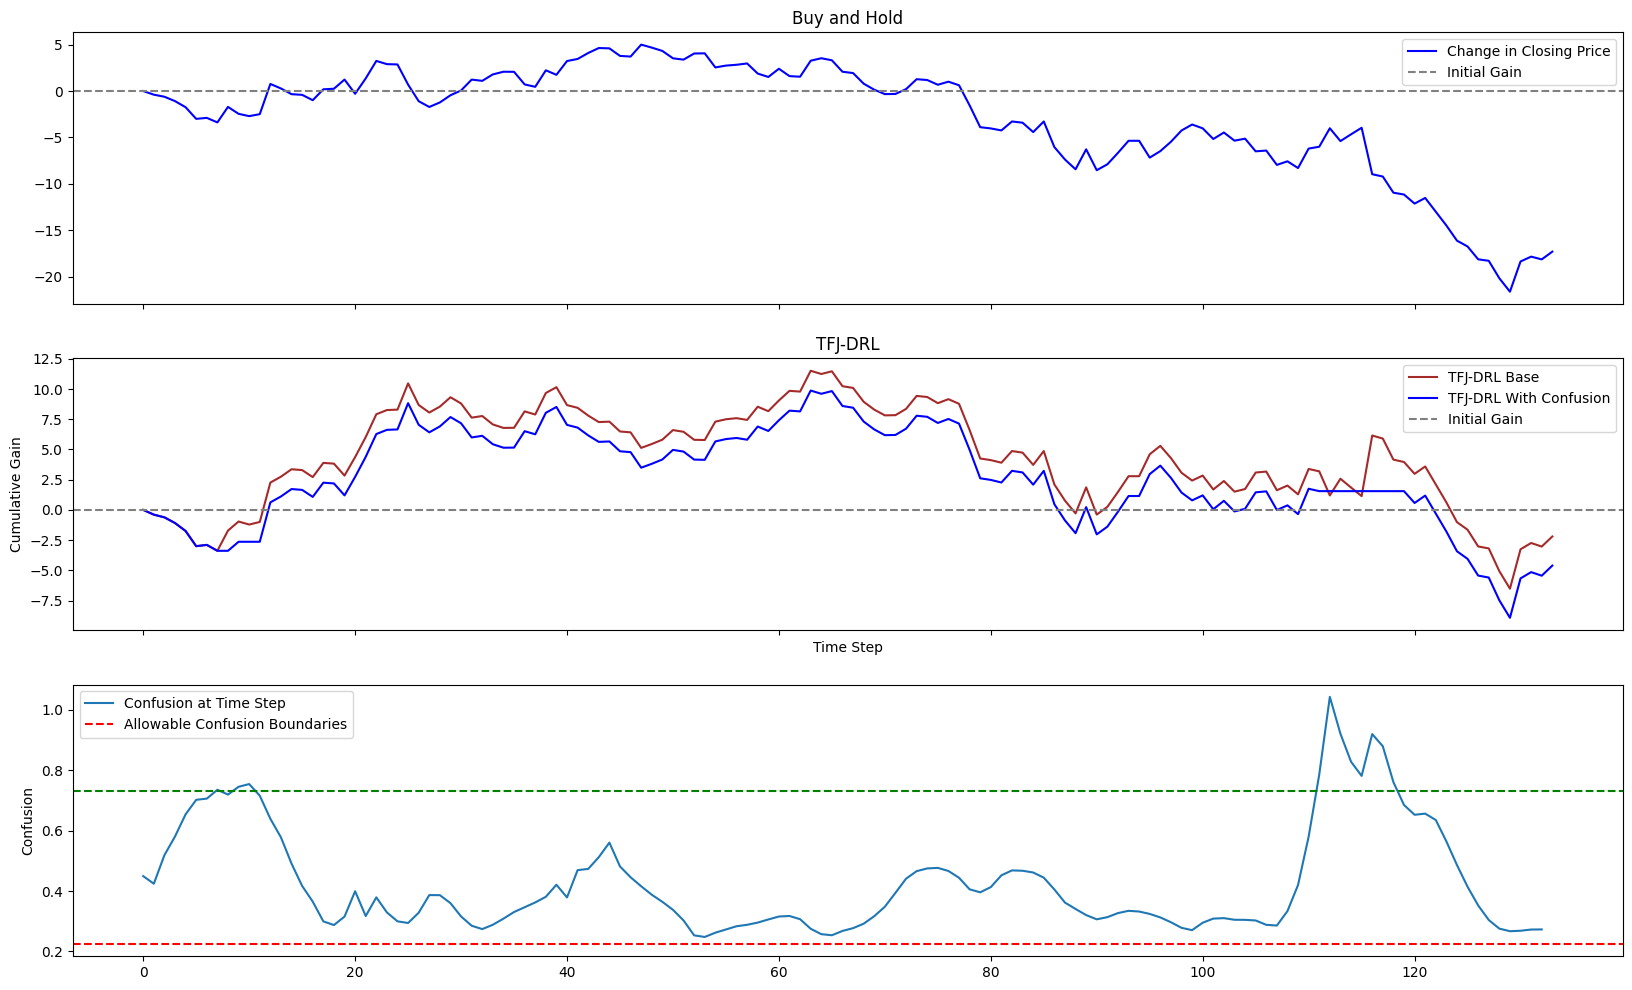

In [ ]:
TFJDRLconf_COF.eval()
avgReturn, avgConf=test(net=TFJDRLconf_COF, test_iter=test_iter, device=DEVICE, epoch=MAX_EPOCH, name=NAME+'COF')
print(f'The average confusion level is: {avgConf:.3f}')
# compute conf thresholds
conf_bounds_COF = np.quantile(conf_data_COF, (.1 , .80))
demo_iter = DataIterGen_V2(1, stockList1, demo=True, window=WINDOW)
test_result, conf, stock_change, baseReturn = demo(net=TFJDRLconf_COF, demo_iter=demo_iter, device=DEVICE, epoch=MAX_EPOCH, name=NAME+'COF', conf_bounds=conf_bounds_COF)
fig, ax = show_demo(result=test_result, stock_change=stock_change, baseline=baseReturn, conf_list=conf, conf_bounds=conf_bounds_COF)
plt.show()